<a href="https://colab.research.google.com/github/yuliyabohdan/Facial-Keypoint-Detection/blob/main/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!jupyter nbconvert --to script config.ipynb
!jupyter nbconvert --to script utils.ipynb
import torch
import cv2
import pandas as pd
import numpy as np
import config
import utils
from torch.utils.data import Dataset, DataLoader

In [ ]:
def train_test_split(csv_path, split):
    df_data = pd.read_csv(csv_path)
    len_data = len(df_data)
    # calculate the validation data sample length
    valid_split = int(len_data * split)
    # calculate the training data samples length
    train_split = int(len_data - valid_split)
    training_samples = df_data.iloc[:train_split][:]
    valid_samples = df_data.iloc[-valid_split:][:]
    return training_samples, valid_samples

In [ ]:
class FaceKeypointDataset(Dataset):
  def __init__(self, samples, path):
    self.data = samples
    self.path = path
    self.resize = 224
    
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, index):   
    image = cv2.imread(f"{self.path}/{self.data.iloc[index][0]}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_h, orig_w, channel = image.shape
    # resize the image into `resize` defined above
    image = cv2.resize(image, (self.resize, self.resize))
    # again reshape to add grayscale channel format
    image = image / 255.0
    # transpose for getting the channel size to index 0
    image = np.transpose(image, (2, 0, 1))
    # get the keypoints
    keypoints = self.data.iloc[index][1:]
    keypoints = np.array(keypoints, dtype='float32')
    # reshape the keypoints
    keypoints = keypoints.reshape(-1, 2)
    # rescale keypoints according to image resize
    keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
    return {'image': torch.tensor(image, dtype=torch.float), 'keypoints': torch.tensor(keypoints, dtype=torch.float)}
              

In [ ]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"train.csv",
                                                   config.TEST_SPLIT)

In [ ]:
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointDataset(training_samples, 
                                 f"train")
valid_data = FaceKeypointDataset(valid_samples, 
                                 f"train")
# prepare data loaders
train_loader = DataLoader(train_data, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=True)
valid_loader = DataLoader(valid_data, 
                          batch_size=config.BATCH_SIZE, 
                          shuffle=False)
print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

Training sample instances: 4500
Validation sample instances: 500


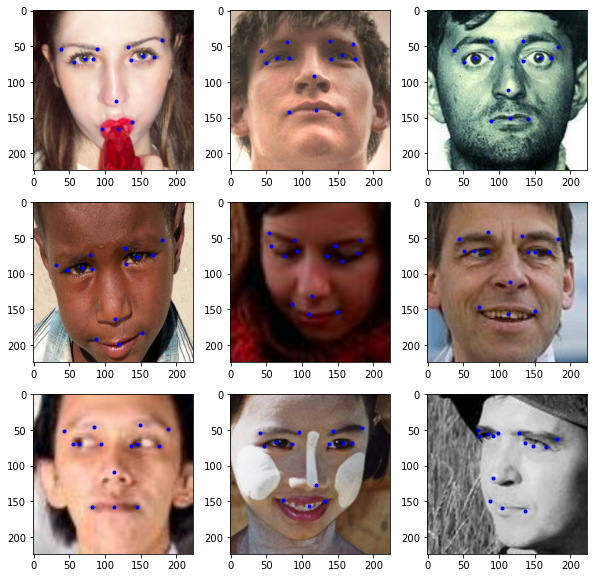

In [ ]:
# whether to show dataset keypoint plots
if config.SHOW_DATASET_PLOT:
    utils.dataset_keypoints_plot(valid_data)